# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Ghifari Fikri Yulistia
- **Email:** ghifari.fikri.yulistia@gmail.com
- **ID Dicoding:** ghifarifikri

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from collections import defaultdict

## Data Preparation

### Data Loading

In [3]:
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


### Data Preprocessing

#### Split Dataset

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/intel-image-classification/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(150, 150),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/intel-image-classification/seg_train/seg_train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(150, 150),
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/intel-image-classification/seg_test/seg_test',
    image_size=(150, 150),
    batch_size=32
)

seg_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/intel-image-classification/seg_pred',
    image_size=(150, 150),
    batch_size=32
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


In [5]:
class_names = train_ds.class_names
print("Kelas pada dataset: ", class_names)

Kelas pada dataset:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Distribusi Kelas (Training): defaultdict(<class 'int'>, {'sea': 1818, 'street': 1907, 'mountain': 2012, 'glacier': 1941, 'buildings': 1752, 'forest': 1798})


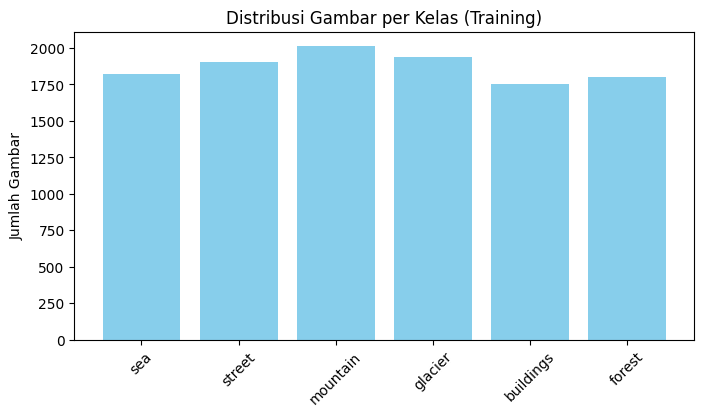

In [6]:
def count_images_per_class(dataset):
    class_names = dataset.class_names
    class_count = defaultdict(int)

    for images, labels in dataset:
        labels = labels.numpy()
        for label in labels:
            class_count[class_names[label]] += 1

    return class_count

train_class_distribution = count_images_per_class(train_ds)
print("Distribusi Kelas (Training):", train_class_distribution)

plt.figure(figsize=(8,4))
plt.bar(train_class_distribution.keys(), train_class_distribution.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Distribusi Gambar per Kelas (Training)")
plt.ylabel("Jumlah Gambar")
plt.show()

Distribusi Kelas (Training): defaultdict(<class 'int'>, {'glacier': 553, 'forest': 474, 'street': 501, 'buildings': 437, 'sea': 510, 'mountain': 525})


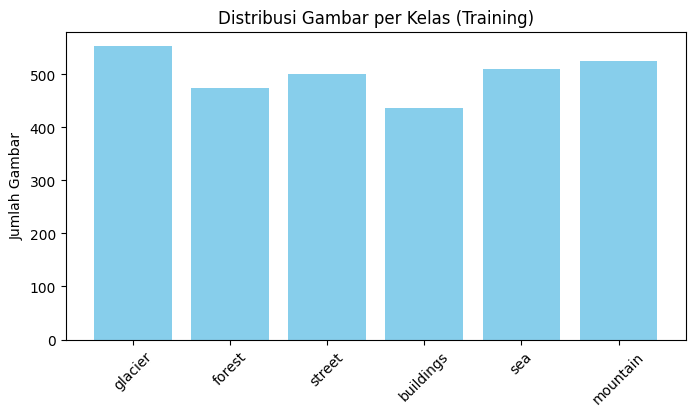

In [7]:
test_class_distribution = count_images_per_class(test_ds)
print("Distribusi Kelas (Training):", test_class_distribution)

plt.figure(figsize=(8,4))
plt.bar(test_class_distribution.keys(), test_class_distribution.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Distribusi Gambar per Kelas (Training)")
plt.ylabel("Jumlah Gambar")
plt.show()

Distribusi Kelas (Training): defaultdict(<class 'int'>, {'mountain': 500, 'buildings': 439, 'glacier': 463, 'street': 475, 'sea': 456, 'forest': 473})


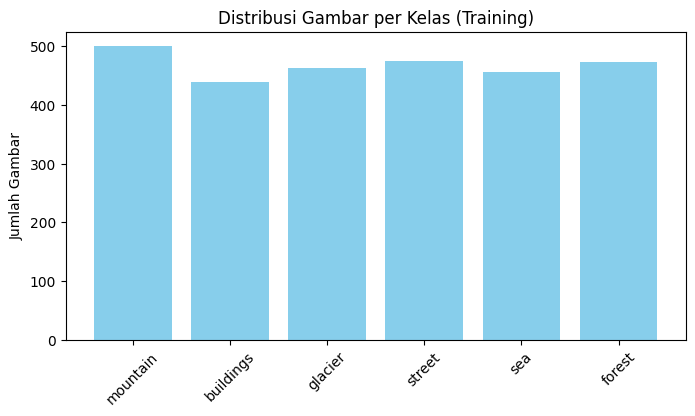

In [8]:
validation_class_distribution = count_images_per_class(val_ds)
print("Distribusi Kelas (Training):", validation_class_distribution)

plt.figure(figsize=(8,4))
plt.bar(validation_class_distribution.keys(), validation_class_distribution.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Distribusi Gambar per Kelas (Training)")
plt.ylabel("Jumlah Gambar")
plt.show()

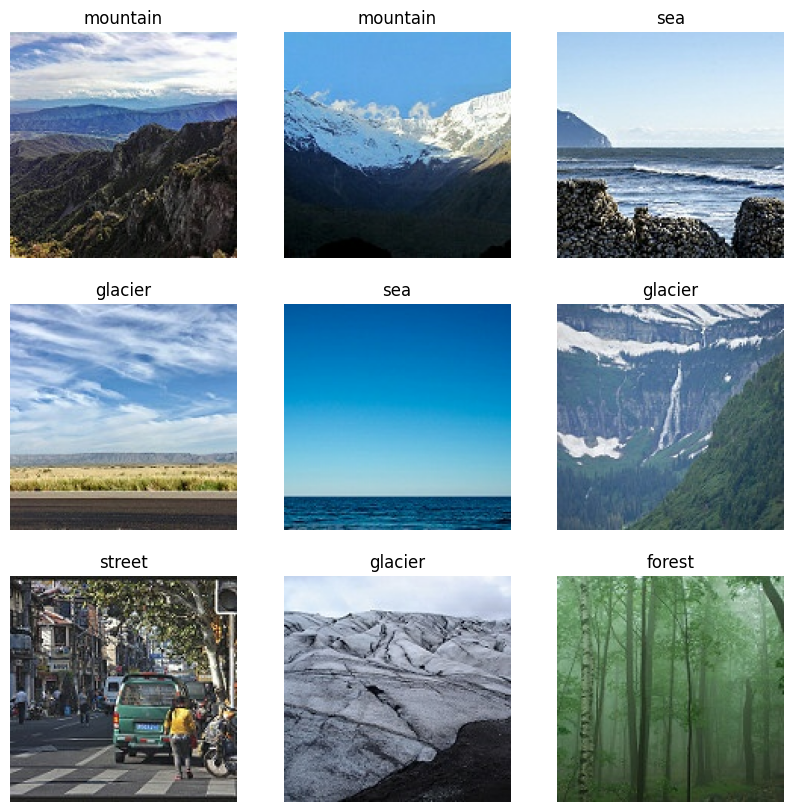

In [9]:
def show_images(dataset, class_names, n=9):
    plt.figure(figsize=(10,10))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

show_images(train_ds, train_ds.class_names)

In [10]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Image dtype:", images.dtype)

Image batch shape: (32, 150, 150, 3)
Label batch shape: (32,)
Image dtype: <dtype: 'float32'>


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
seg_ds = seg_ds.prefetch(buffer_size=AUTOTUNE)

## Modelling

In [12]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-5
    )
]

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.4693 - loss: 1.3068 - val_accuracy: 0.6272 - val_loss: 0.9465 - learning_rate: 0.0100
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6665 - loss: 0.8671 - val_accuracy: 0.7281 - val_loss: 0.7232 - learning_rate: 0.0100
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7346 - loss: 0.7018 - val_accuracy: 0.7202 - val_loss: 0.7402 - learning_rate: 0.0100
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7844 - loss: 0.5673 - val_accuracy: 0.7537 - val_loss: 0.7001 - learning_rate: 0.0100
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8537 - loss: 0.3961 - val_accuracy: 0.7359 - val_loss: 0.9088 - learning_rate: 0.0100
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8902 - loss: 0.2967 - val_accuracy: 0.7666 - val_loss: 1.0281 - learning_rate: 0.0100
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9446 - lo

## Evaluasi dan Visualisasi

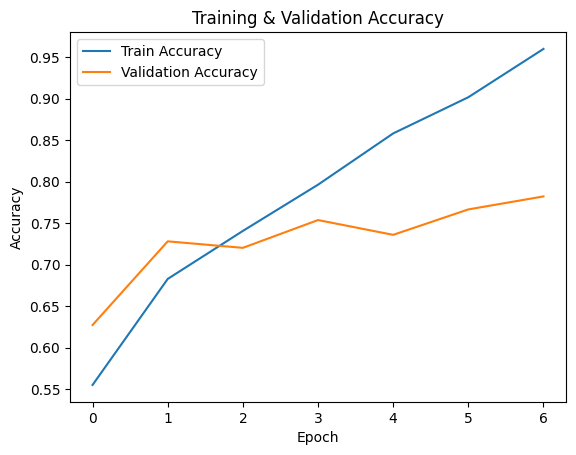

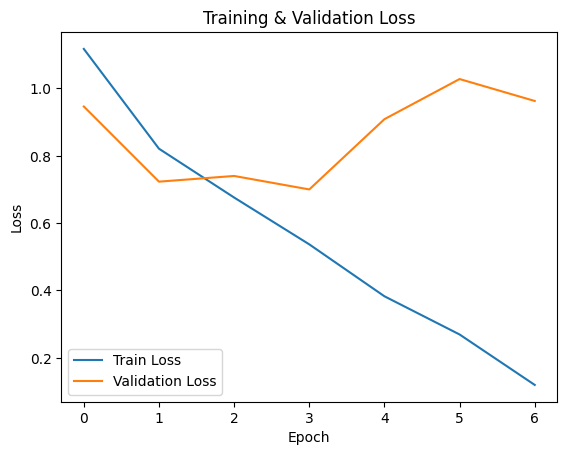

In [16]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

## Konversi Model

In [17]:
saved_model_dir = "saved_model"
model.export(saved_model_dir)  # Gantilah 'model' sesuai nama model kamu

# === 2. Konversi ke TFLite ===
tflite_dir = "tflite"
os.makedirs(tflite_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(os.path.join(tflite_dir, "model.tflite"), "wb") as f:
    f.write(tflite_model)

# === 3. Simpan label.txt ===
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
with open(os.path.join(tflite_dir, "label.txt"), "w") as f:
    for label in labels:
        f.write(label + "\n")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134985252449232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252454224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252454032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252450960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252453264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252451536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252453840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252701008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252701968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134985252702928: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [18]:
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  saved_model \
  tfjs_model

2025-04-20 12:37:00.434390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745152620.465682    1420 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745152620.475494    1420 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-20 12:37:05.785513: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745152625.785685    1420 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


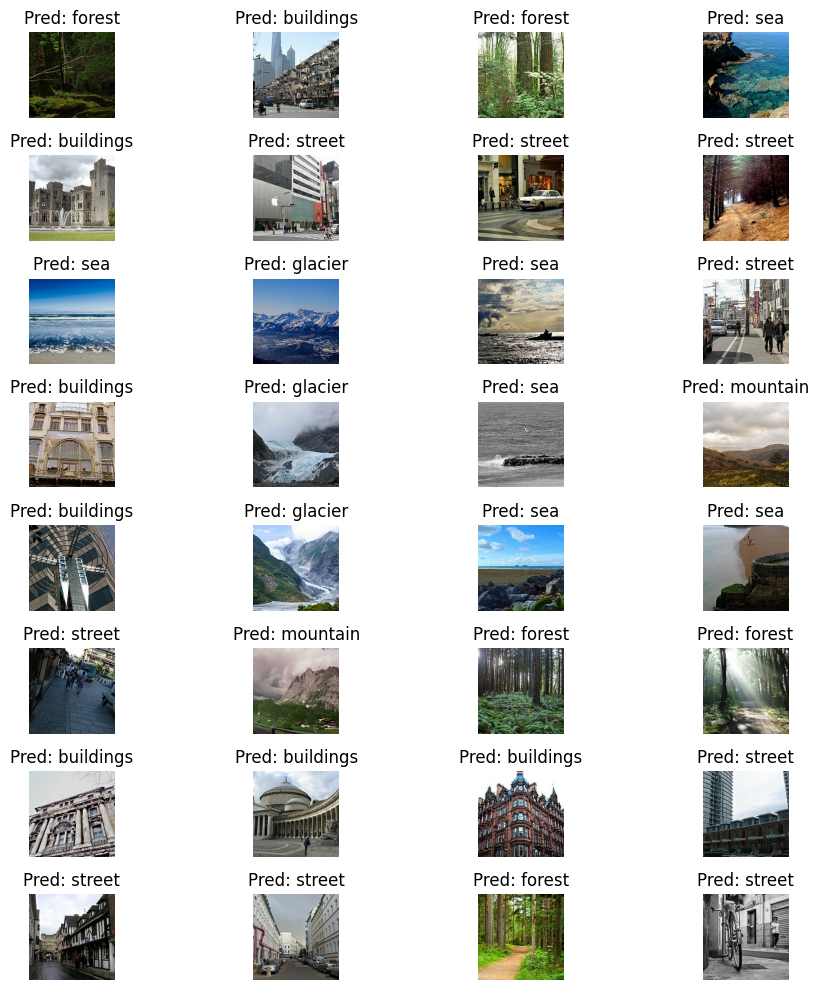

In [19]:
for images, labels in seg_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()
    predicted_class_names = [class_names[i] for i in predicted_classes]

    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {predicted_class_names[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()